# Building a Predictive Model for McAfee V3

## 1. Notebook Styling and Package Management

In [215]:
import numpy as np # Library for math operations
import pandas as pd # Library for data handling
import sklearn # The machine learning library we will be using in this entire course
from sklearn import tree # Tree function is used for visualizing decision tree
from sklearn.metrics import * # Importing function that can be used to calculate different metrics
from sklearn.tree import DecisionTreeClassifier # Importing Decision Tree Classifier 
from sklearn.ensemble import RandomForestClassifier  # Importing Random Forest Classifier 
from sklearn.model_selection import train_test_split # Importing function that can split a dataset into training and testing set
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler # Importing function for scaling the data
from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV # Importing GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier # Importing the XGBoost Classifier 
import matplotlib.pyplot as plt # Importing the package for plotting
plt.style.use('fivethirtyeight') # Use the styling from FiveThirtyEight Website
import seaborn as sns # Importing another package for plotting

from custom_functions import plot_conf_mat, plot_roc_curve, plot_feature_importance, calculateMetricsAndPrint

## 2. Load Data

In [216]:
trainInput = pd.read_csv("Data/Phishing_TrainSample.csv") 
testInput = pd.read_csv("Data/Phishing_TestSample.csv")

In [217]:
trainData = trainInput.drop(columns = 'Visit')
trainLabels = LabelEncoder().fit_transform(trainInput.Visit)

testData = testInput.drop(columns = 'Visit')
testLabels = LabelEncoder().fit_transform(testInput.Visit)

## 3. Data Augmentations

In [38]:
!pip install feature-engine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.0/290.0 kB 6.4 MB/s eta 0:00:0000:01


### 3.1. Treat Outliers

In [218]:
from feature_engine.outliers import Winsorizer

out = Winsorizer(tail = "both")

cap_trainData, cap_testData = out.fit_transform(trainData), out.transform(testData)

### 3.2. Remove Redundant Features

In [219]:
cap_trainData.shape

(54384, 28)

In [220]:
from feature_engine.selection import SelectByInformationValue

cor = SelectByInformationValue(threshold = .001)

cor_trainData, cor_testData = cor.fit_transform(cap_trainData,trainLabels), cor.transform(cap_testData)

In [221]:
cor_trainData.shape

(54384, 27)

### 3.3. Add New Features

In [222]:
from feature_engine.creation import MathFeatures

mf = MathFeatures(variables = ['Tool_Det_Accuracy', 'Tool_Warning'], 
                  func = "sum")

mf_trainData, mf_testData = mf.fit_transform(cor_trainData), mf.fit_transform(cor_testData)

In [223]:
mf_trainData.shape

(54384, 28)

### 3.4. SMOTE to Balance Samples

In [224]:
trainLabels.mean()

0.3481906443071492

In [225]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE(random_state=1, k_neighbors = 5, sampling_strategy = "not majority")
strainData, strainLabels = oversample.fit_resample(mf_trainData, trainLabels)

In [226]:
strainLabels.mean()

0.5

Use the augmented data in RF and test it in testData:

In [227]:
clf = RandomForestClassifier(random_state = 1)
clf.fit(strainData, strainLabels)
predictedProbabilities = clf.predict_proba(mf_testData)
predictedLabels = clf.predict(mf_testData) 
calculateMetricsAndPrint(predictedLabels, predictedProbabilities, testLabels)

Accuracy: 75.43
PrecisionNegative: 93.94
PrecisionPositive: 58.28
RecallNegative: 67.60
RecallPositive: 91.22
AUC Score: 85.63



Compare with original train:

In [228]:
clf = RandomForestClassifier(random_state = 1)
clf.fit(trainData, trainLabels)
predictedProbabilities = clf.predict_proba(testData)
predictedLabels = clf.predict(testData) 
calculateMetricsAndPrint(predictedLabels, predictedProbabilities, testLabels)

Accuracy: 74.93
PrecisionNegative: 93.95
PrecisionPositive: 57.71
RecallNegative: 66.80
RecallPositive: 91.33
AUC Score: 85.31



## 4. Select Algorithms

### 4.1. AutoML

Docs: https://supervised.mljar.com

In [176]:
!pip install mljar-supervised

  Using cached mljar_supervised-0.11.5-py3-none-any.whl
  Using cached optuna-3.0.5-py3-none-any.whl (348 kB)
  Using cached Markdown-3.4.1-py3-none-any.whl (93 kB)
  Using cached scikit_plot-0.3.7-py3-none-any.whl (33 kB)
  Using cached cmaes-0.9.1-py3-none-any.whl (21 kB)
  Using cached colorlog-6.7.0-py2.py3-none-any.whl (11 kB)
  Using cached scipy-1.8.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (42.2 MB)
  Using cached cliff-4.1.0-py3-none-any.whl (81 kB)
  Using cached prettytable-3.6.0-py3-none-any.whl (27 kB)
  Using cached autopage-0.5.1-py3-none-any.whl (29 kB)
  Using cached stevedore-4.1.1-py3-none-any.whl (50 kB)
  Using cached cmd2-2.4.2-py3-none-any.whl (147 kB)
  Using cached pyperclip-1.8.2-py3-none-any.whl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 2.9 MB/s eta 0:00:0000:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.9.1
    Uninstalling scipy-1.9.1:
      Successfully uninstalled scipy-1.9.1
ERROR: pip's de

In [179]:
from supervised.automl import AutoML

Since it will take a long time to try this on the entire training data, we just use a randomly drawn sample from the training data:

In [182]:
%%capture --no-display
aml = AutoML(model_time_limit = 50,
                     eval_metric="auc",
                     algorithms=["CatBoost", "LightGBM", "Xgboost"],
                     validation_strategy={
        "validation_type": "kfold",
        "k_folds": 5,
        "shuffle": False,
        "stratify": True,
    }
                    )

aml.fit(strainData, strainLabels)

/opt/conda/lib/python3.10/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[ 2.          4.          1.         ... 37.14424017 37.14424017
   5.        ]
 [ 2.          4.          3.         ...  5.          5.
   3.        ]
 [ 9.16666667  7.66666667  8.66666667 ...  4.53333333  4.53333333
   6.96666667]
 ...
 [ 2.          1.          8.         ...  1.          1.
   5.        ]
 [ 1.          1.          1.         ...  1.          1.
   1.        ]
 [ 4.          7.          4.         ...  3.          3.
   6.        ]] loaded from the file /tmp/joblib_memmapping_folder_108_48e0cf3667a54084a197fc8de90fb0b4_09a2ca1c23004fc9bd2806a5ea9fd89c/108-139779313219280-bc1847f5fd394dd1bb7bc2a9bcd3c729.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pickle file with joblib >= 1.2.0. See https://github.com/joblib/joblib/issues/563 fo

AutoML(algorithms=['CatBoost', 'LightGBM', 'Xgboost'], eval_metric='auc',
       model_time_limit=50,
       validation_strategy={'k_folds': 4, 'shuffle': False, 'stratify': True,
                            'validation_type': 'kfold'})

In [192]:
# aml.report()

In [184]:
predictedProbabilities = aml.predict_proba(mf_testData)
predictedLabels = aml.predict(mf_testData) 
calculateMetricsAndPrint(predictedLabels, predictedProbabilities, testLabels)

Accuracy: 75.52
PrecisionNegative: 93.20
PrecisionPositive: 58.52
RecallNegative: 68.37
RecallPositive: 89.94
AUC Score: 87.03



#### 4.2. Saving the Model on File:

In [185]:
import pickle
filename = 'aml.sav'
pickle.dump(aml, open(filename, 'wb'))

To load the model again (the next time we want to use it):

In [23]:
filename = 'aml.sav'
loaded_model = pickle.load(open(filename, 'rb'))

## 5. Fine-tune the HyperParameters for XGBoost

### 5.1. HyperOpt:

In [193]:
!pip install hyperopt

  Using cached hyperopt-0.2.7-py2.py3-none-any.whl (1.6 MB)
  Using cached py4j-0.10.9.7-py2.py3-none-any.whl (200 kB)


In [229]:
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform('n_estimators', 100, 200, 20),
        'eta': hp.uniform ('eta', 0.1,0.9),
        'seed': 0,
        'random_state': 1
    }

from sklearn.metrics import roc_auc_score

def objective(space):
    clf=XGBClassifier(
        random_state = space['random_state'],
        eta = space['eta'],
        n_estimators = int(space['n_estimators']), 
        max_depth = int(space['max_depth']), 
        gamma = space['gamma'],
        reg_alpha = int(space['reg_alpha']),
        min_child_weight=int(space['min_child_weight']),
        colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( strainData, strainLabels), ( mf_testData, testLabels)]
    
    clf.fit(strainData, strainLabels,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(mf_testData)
    accuracy = roc_auc_score(testLabels, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [230]:
%%capture --no-display

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

In [231]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.7757145008532934, 'eta': 0.7386133644150247, 'gamma': 3.9823204061610724, 'max_depth': 16.0, 'min_child_weight': 10.0, 'n_estimators': 140.0, 'reg_alpha': 45.0, 'reg_lambda': 0.6647653355860037}


In [233]:
best_hyperparams = {'colsample_bytree': 0.7757145008532934, 'eta': 0.7386133644150247, 
                    'gamma': 3.9823204061610724, 'max_depth': 16, 'min_child_weight': 10, 
                    'n_estimators': 140, 'reg_alpha': 45.0, 'reg_lambda': 0.6647653355860037}

best_xgb = XGBClassifier(**best_hyperparams, random_state=1)
best_xgb.fit(strainData, strainLabels)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.7757145008532934, early_stopping_rounds=None,
              enable_categorical=False, eta=0.7386133644150247,
              eval_metric=None, feature_types=None, gamma=3.9823204061610724,
              gpu_id=-1, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.738613367,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=16, max_leaves=0, min_child_weight=10,
              missing=nan, monotone_constraints='()', n_estimators=140,
              n_jobs=0, num_parallel_tree=1, predictor='auto', ...)

In [234]:
predictedProbabilities = best_xgb.predict_proba(mf_testData)
predictedLabels = best_xgb.predict(mf_testData) 
calculateMetricsAndPrint(predictedLabels, predictedProbabilities, testLabels)

Accuracy: 73.94
PrecisionNegative: 93.03
PrecisionPositive: 56.75
RecallNegative: 65.95
RecallPositive: 90.05
AUC Score: 85.86



### 5.2. Manual Tuning Using Log-Loss:

We can use Log-Loss as a metric for evaluating classifiers. Below, we use Log-Loss to determine when the model starts to make poor predictions on testData. 

In the example, we set max_depth to be 4 and eta (learning_rate) to be 0.1. Initially, we also set the number of estimators (n_estimators) to be 500. Later, we learn what would be the optimal value for n_estimators when max_depth is 4 and eta is 0.1:

In [235]:
clf = XGBClassifier(random_state=1, eval_metric="logloss", objective = "binary:logistic",
                   disable_default_eval_metric=True, 
                    n_estimators = 500, eta = .1, max_depth = 4)

eval_set = [(strainData, strainLabels), (mf_testData, testLabels)]

clf.fit(strainData, strainLabels, eval_set = eval_set, verbose = False)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              disable_default_eval_metric=True, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric='logloss',
              feature_types=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.100000001, max_bin=256, max_cat_threshold=64,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=4, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=0, num_parallel_tree=1, ...)

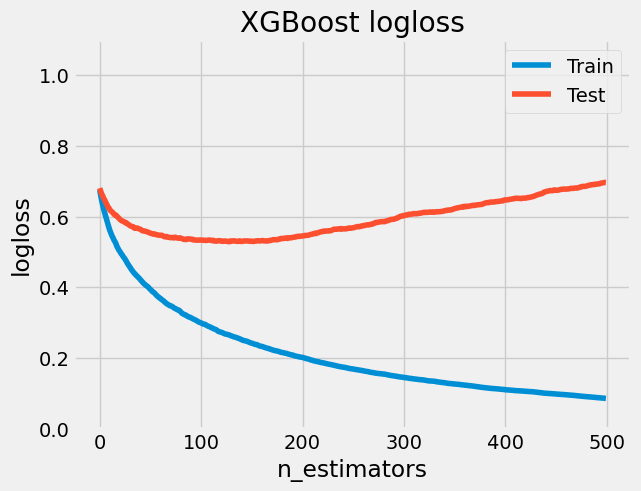

In [236]:
# retrieve performance metrics
results = clf.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.set_ylim(0,1.1)
ax.legend()
plt.ylabel('logloss')
plt.xlabel('n_estimators')
plt.title('XGBoost logloss')
plt.show()

As you can see in this case, the log-loss continues to decline for the training data. However, roughly around n_estimators = 140, we see the log-loss is minimum for this model. Therefore, we select n_estimators to be 140:

In [237]:
clf = XGBClassifier(random_state=1, eval_metric="logloss", objective = "binary:logistic",
                   disable_default_eval_metric=True, 
                    n_estimators = 140, eta = .1, max_depth = 4)

clf.fit(strainData, strainLabels)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              disable_default_eval_metric=True, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric='logloss',
              feature_types=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.100000001, max_bin=256, max_cat_threshold=64,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=4, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=140, n_jobs=0, num_parallel_tree=1, ...)

To do all of this automatically, we could use a HyperParameter in XGBoost called early_stopping_rounds. This parameter controls model's patience for how many iterations it will wait for the next decrease in the loss value. Let's use it and see how it works:

In [239]:
clf = XGBClassifier(random_state=1, eval_metric="logloss", objective = "binary:logistic",
                   disable_default_eval_metric=True, eta = .1, max_depth = 4,
                   n_estimators = 500, early_stopping_rounds = 15)

eval_set = [(strainData, strainLabels), (mf_testData, testLabels)]

clf.fit(strainData, strainLabels, eval_set = eval_set, verbose = True)

[0]	validation_0-logloss:0.67510	validation_1-logloss:0.68020
[1]	validation_0-logloss:0.65933	validation_1-logloss:0.67099
[2]	validation_0-logloss:0.64387	validation_1-logloss:0.66325
[3]	validation_0-logloss:0.63122	validation_1-logloss:0.65803
[4]	validation_0-logloss:0.61937	validation_1-logloss:0.65077
[5]	validation_0-logloss:0.60919	validation_1-logloss:0.64620
[6]	validation_0-logloss:0.59977	validation_1-logloss:0.63940
[7]	validation_0-logloss:0.58825	validation_1-logloss:0.63395
[8]	validation_0-logloss:0.57752	validation_1-logloss:0.62732
[9]	validation_0-logloss:0.56940	validation_1-logloss:0.62435
[10]	validation_0-logloss:0.56051	validation_1-logloss:0.61885
[11]	validation_0-logloss:0.55345	validation_1-logloss:0.61533
[12]	validation_0-logloss:0.54582	validation_1-logloss:0.61347
[13]	validation_0-logloss:0.54029	validation_1-logloss:0.61065
[14]	validation_0-logloss:0.53371	validation_1-logloss:0.60698
[15]	validation_0-logloss:0.52892	validation_1-logloss:0.60425
[1

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              disable_default_eval_metric=True, early_stopping_rounds=15,
              enable_categorical=False, eta=0.1, eval_metric='logloss',
              feature_types=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.100000001, max_bin=256, max_cat_threshold=64,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=4, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=0, num_parallel_tree=1, ...)

In the output, we can see that even though n_estimators was set at 500, the model only used 144 estimators. This is due to the use of early_stopping_rounds. 

In [240]:
predictedProbabilities = clf.predict_proba(mf_testData)
predictedLabels = clf.predict(mf_testData) 
calculateMetricsAndPrint(predictedLabels, predictedProbabilities, testLabels)

Accuracy: 73.85
PrecisionNegative: 91.95
PrecisionPositive: 56.81
RecallNegative: 66.72
RecallPositive: 88.22
AUC Score: 85.75



## 6. LightGBM:

In [245]:
from lightgbm import LGBMClassifier

lg = LGBMClassifier(random_state=1)
lg.fit(strainData, strainLabels)

LGBMClassifier(random_state=1)

In [246]:
predictedProbabilities = lg.predict_proba(mf_testData)
predictedLabels = lg.predict(mf_testData) 
calculateMetricsAndPrint(predictedLabels, predictedProbabilities, testLabels)

Accuracy: 76.31
PrecisionNegative: 92.81
PrecisionPositive: 59.55
RecallNegative: 69.99
RecallPositive: 89.07
AUC Score: 86.99



## 7. CatBoost:

In [247]:
from catboost import CatBoostClassifier

cat = CatBoostClassifier(random_state=1)
cat.fit(strainData, strainLabels, verbose=False)

In [248]:
predictedProbabilities = cat.predict_proba(mf_testData)
predictedLabels = cat.predict(mf_testData) 
calculateMetricsAndPrint(predictedLabels, predictedProbabilities, testLabels)

Accuracy: 76.12
PrecisionNegative: 94.09
PrecisionPositive: 59.05
RecallNegative: 68.59
RecallPositive: 91.31
AUC Score: 86.34



## What is next?

You can use hyperopt to finetune lightgbm and catboost. 

See the examples here: https://www.kaggle.com/code/eikedehling/tune-and-compare-xgb-lightgbm-rf-with-hyperopt/notebook and https://www.kaggle.com/code/redroy44/catboost-hyperopt

## 8. Apply to Kaggle Test:

In [249]:
kaggleTest = pd.read_csv("Data/Phishing_KaggleTest.csv") 

Apply all data transformations:

In [250]:
cap_kaggleTest = out.transform(kaggleTest)
cor_kaggleTest = cor.transform(cap_kaggleTest)
mf_kaggleTest = mf.fit_transform(cor_kaggleTest)

Add index and apply the classifier with the highest AUC (LightGBM):

In [251]:
mf_kaggleTest['id'] = mf_kaggleTest.index
mf_kaggleTest['score'] = lg.predict_proba(mf_kaggleTest.drop(columns = 'id'))[:,1]
mf_kaggleTest[['id','score']].to_csv("Data/Kaggle_Submission.csv", index = False)